In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [202]:
# Helper Functions

# Iterate across trials and convert csvs to a list of dataframes
def csv_to_df(directory):
    processes = [[], [], []]
    for filename in os.listdir(directory):
        trial = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isdir(trial):
            sorted_list = sorted(os.listdir(trial))
            for i, log in enumerate(sorted_list):
                log_path = os.path.join(trial, log)
                processes[i].append(pd.read_csv(log_path))

    return processes

# Average results across dataframes
def average_dfs(processes, col_name):
    data = []
    for i in range(3):
        cols = []
        minimum = len(processes[i][0][col_name])
        for j in range(3):
            col = processes[i][j][col_name]
            cols.append(col)
            minimum = min(minimum, len(col))
        normalized = []
        for k in range(3):
            normalized.append(cols[k][:minimum])
        val = pd.concat([normalized[0], normalized[1], normalized[2]]).groupby(level=0).mean()
        data.append(val)

    return data

# Graph results
def graph(directory, col_name, crs=None):
    processes = csv_to_df(directory)
    data = average_dfs(processes, col_name)
    global_time = average_dfs(processes, 'global time')
    if crs:
        for i in range(3):
            data[i] /= crs[i]
    plt.plot(global_time[0], data[0])
    plt.plot(global_time[1], data[1])
    plt.plot(global_time[2], data[2])

    name = col_name.split(" ")
    first = name[0].capitalize()
    second = name[1].capitalize()
    log = directory.split('/')[1].capitalize()

    title = f"{log}: {first} {second} Comparison"
    plt.title(title)
    plt.xlabel('Global Time (seconds)')
    plt.ylabel(f"{first} {second}")
    plt.show()

def graph_events(directory, crs):
    log = directory.split('/')[1].capitalize()
    processes = csv_to_df(directory)
    data = []
    for i in range(3):
        cols = []
        for j in range(3):
            col = processes[i][j]['event type'].value_counts()
            cols.append(col)
        val = pd.concat([cols[0], cols[1], cols[2]]).groupby(level=0).mean()
        indices = val.index.to_list()
        data.append(val)

    fig, axs = plt.subplots(3, figsize=(10, 10))
    fig.tight_layout(pad=5.0)
    fig.suptitle(f'Event Comparison: {log}')
    for i in range(3):
        axs[i].bar(indices, data[i], color=['blue', 'red', 'green'], width = 0.4)
        axs[i].set_title(f"Clock Rate: {crs[i]}")
    plt.show()


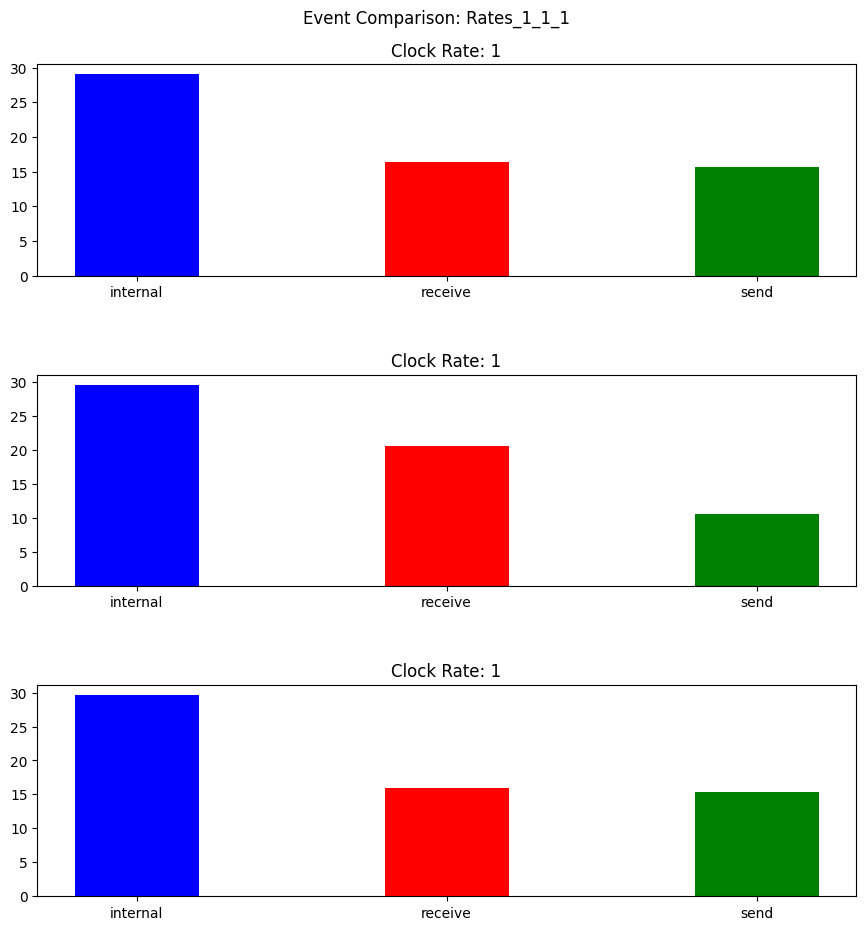

In [203]:
graph_events('logs/rates_1_1_1', [1, 1, 1])

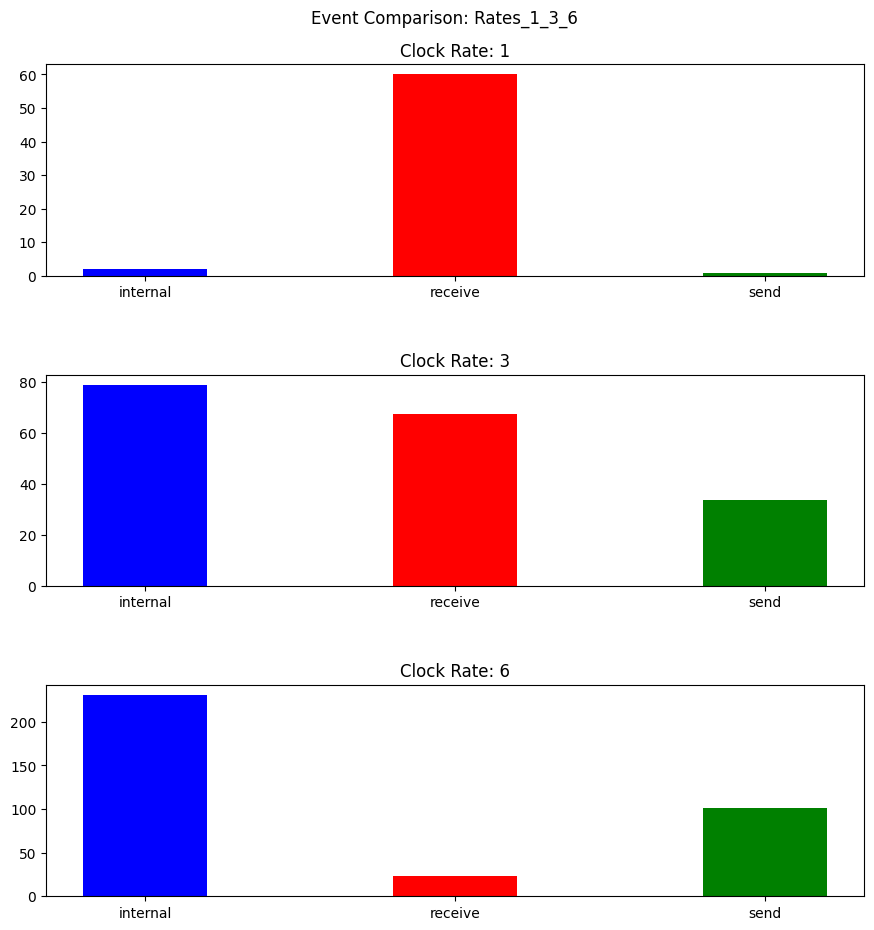

In [205]:
graph_events('logs/rates_1_3_6', [1, 3, 6])

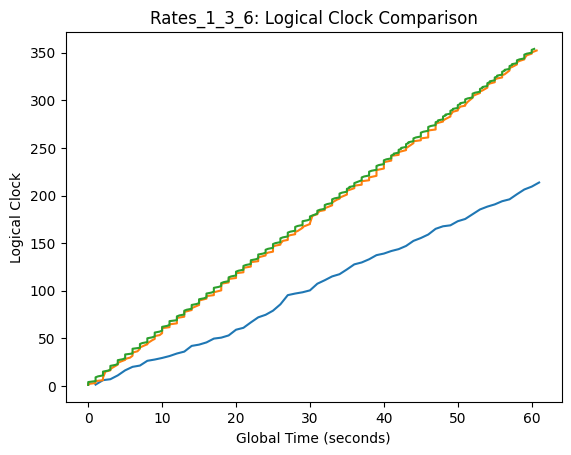

In [144]:
graph('logs/rates_1_3_6', 'logical clock')

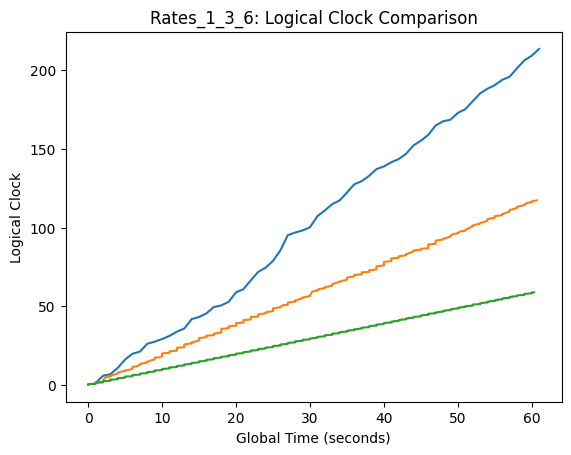

In [206]:
graph('logs/rates_1_3_6', 'logical clock', [1, 3, 6])